# Data Source and Project Goal

***Dataset Link*** - https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+dataInbox

***About*** - The dataset is about bankruptcy prediction of Polish companies. The data was collected from Emerging Markets Information Service (EMIS, http://www.securities.com), which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.


***Project Goal*** - The goal is to predict a firm's bankruptcy status given it's financial metrics for a specific forecasting period.

# Load Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from scipy import stats
from scipy.io import arff

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, HistGradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline

# Load Methods

In [2]:
def load_data(input):
    ''' Iterates through the input directory and loads each .arff file corresponding to each forecasting period,
        renames the attributes with the correct column names,
        converts the class variable values from object type to binary (b'0' to 0 and b'1' to 1),
        and returns a dictionary of dataframes indexed by number of forecasting years'''

    dfs = {}

    column_mappings_df = pd.read_csv('./columns.csv')
    column_mappings_dict = dict(zip(column_mappings_df['attr'], column_mappings_df['column']))

    for index, file in enumerate(os.listdir(INPUT_DATA_PATH)):
        temp_df = pd.DataFrame(arff.loadarff(INPUT_DATA_PATH + file)[0])
        temp_df.rename(columns=column_mappings_dict, inplace=True)
        temp_df = temp_df.astype({'class': int})
        dfs[file.split("year")[0]] = temp_df

    return dfs

def basic_counts(dfs):
    '''Creates a summary table with class counts for each forecasting period'''

    columns = ['Forecasting Year', 'Total records', 'Did Not Bankrupt', 'Went Bankrupt', 'Did Not Bankrupt %', 'Went Bankrupt %']
    counts_summary = []

    for index in dfs:
        temp_df = dfs[index]

        temp = []
        temp.append(index)
        temp.append(len(temp_df))
        temp.append(len(temp_df[temp_df['class'] == 0]))
        temp.append(len(temp_df[temp_df['class'] == 1]))
        temp.append(len(temp_df[temp_df['class'] == 0])/len(temp_df) * 100)
        temp.append(len(temp_df[temp_df['class'] == 1])/len(temp_df) * 100)

        counts_summary.append(temp)

    return pd.DataFrame(counts_summary, columns=columns)

def get_summary(df):
    '''Returns summary for a given dataframe'''

    return df.describe().T

def get_nulls_summary(df):
    '''Returns a summary of nulls for a given dataframe'''

    return df.isnull().sum()

def plot_feature_histograms(df, bins):
    '''Plots histograms for all features in a dataframe'''

    df.hist(bins=bins, figsize=(40, 20))
    plt.show()

def plot_box_plot(df, feature):
    '''Plots a box plot to view outliers for a given feature in a dataframe'''

    sns.boxplot(x=feature, data=df)
    plt.show()

def plot_box_plots(df):
    boxplot = df.boxplot(column=list(df.columns), grid=False, rot=90, fontsize=12, figsize=(40, 20))

def remove_features(cutoff_percent, df):
    '''Removes features if percentage of missing values > cutoff_percent'''

    missing_values_summary = df.isnull().sum().sort_values() / len(df)
    missing_values_summary = missing_values_summary.loc[lambda count : count > cutoff_percent]
    remove_features = missing_values_summary.index

    for feature in remove_features:
        df = df.drop(feature, axis=1)
        print('Removed:', feature)

    return df

def knn_impute(df, n_neighbours):
    '''Imputes missing values in a dataframe using the KNNImputer'''

    imputer = KNNImputer(n_neighbors=n_neighbours)
    df_array = imputer.fit_transform(df)
    df = pd.DataFrame(df_array, columns=df.columns, index=df.index)
    return df

def mean_impute(df):
    '''Imputes missing values in a dataframe with the dataframe mean'''

    df = df.fillna(df.mean())
    return df

def remove_outliers_by_z_score(df, feature, limits=[-3,3]):
    '''Removes outliers by z-score within a given limit range'''

    z_scores = stats.zscore(df[feature])
    outliers = (z_scores > limits[1]) | (z_scores < limits[0])
    df = df[~outliers]
    return df

def remove_outliers_by_isolation_forest(df, feature, contamination):
    '''Removes outliers by the Isolation Forest method'''

    clf = IsolationForest(contamination=contamination)
    outliers = clf.fit_predict(df[[feature]])
    outlier_values = df[feature][outliers == -1]

    return df[outliers != -1]

def scale_data_standard(X_train, X_test):
    '''Standard scales the given train and test sets'''

    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_train = pd.DataFrame(std_scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(std_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test

def scale_data_log(X_train, X_test):
    '''Log scales the given train and test sets'''

    pass

def process_data(df, classifier, train_size=0.7, scale=False, scale_method='STANDARD'):
    '''Performs dataset split and scales the dataset'''

    df_0 = df[df[classifier] == 0]
    df_1 = df[df[classifier] == 1]

    y_0 = df_0[classifier]
    X_0 = df_0.drop(classifier, axis=1)

    y_1 = df_1[classifier]
    X_1 = df_1.drop(classifier, axis=1)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, train_size=train_size, random_state=3, shuffle=True)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, train_size=train_size, random_state=3, shuffle=True)

    X_train = X_train_0.append(X_train_1)
    X_test = X_test_0.append(X_test_1)
    y_train = y_train_0.append(y_train_1)
    y_test = y_test_0.append(y_test_1)

    if scale:
      if (scale_method == 'STANDARD'):
          X_train, X_test = scale_data_standard(X_train, X_test)
      elif (scale_method == 'LOG'):
          X_train, X_test = scale_data_log(X_train, X_test)

    return X_train, X_test, y_train, y_test

def baseline(x):
    '''Baseline Model - Always predicts that a firm did not go bankrupt'''

    return 0

def process_pca(X_train, X_test, n_components):
    '''Performs PCA and returns a given number of components'''

    pca = PCA(n_components=n_components)
    pca.fit(X_train)

    X_train_reduced = pd.DataFrame(pca.transform(X_train), index=X_train.index, columns=['PC-' + str(i) for i in range(1, n_components + 1)])
    X_test_reduced = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=['PC-' + str(i) for i in range(1, n_components + 1)])

    return X_train_reduced, X_test_reduced

def balance_by_downsampling(df):
    '''Performs dataset balancing by downsampling'''

    df_majority = df[df['class']==0]
    df_minority = df[df['class']==1]

    df_majority_downsampled = resample(df_majority,
                                    replace=False,
                                    n_samples=len(df_majority),
                                    random_state=1234)

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

def balance_by_upsampling(df):
    '''Performs dataset balancing by upsampling'''
    df_majority = df[df['class']==0]
    df_minority = df[df['class']==1]

    df_minority_upsampled = resample(df_minority,
                                    replace=True,
                                    n_samples=len(df_majority),
                                    random_state=1234)

    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

def balance_by_smote(X_train, y_train, sampling_strategy=0.5):
    '''Performs dataset balancing by SMOTE'''

    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    return smote.fit_resample(X_train, y_train)

def balance_by_down_and_up_sampling(df):
    '''Performs dataset balancing by combining downsampling and upsampling'''

    df_split_1 = df[0:len(df)//2]
    df_split_2 = df[len(df)//2:]

    df_downsampled = balance_by_downsampling(df_split_1)
    df_upsampled = balance_by_upsampling(df_split_2)

    df = pd.concat([df_downsampled, df_upsampled])
    return df

def print_stats(y_pred, t_test):
    print("----------------------------------------------------------")
    test_accuracy = np.sum(y_pred == y_test)/len(y_test)
    print('Test Accuracy -', '{:.2f}%'.format(test_accuracy * 100), "\n")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\n", end="")
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    print("----------------------------------------------------------")

# Data Exploration

In [3]:
INPUT_DATA_PATH = './Data/'

# Dictionary of dataframes index by forecasting period (1 to 5)
dfs = load_data(INPUT_DATA_PATH)

In [222]:
basic_counts(dfs)

,Forecasting Year,Total records,Did Not Bankrupt,Went Bankrupt,Did Not Bankrupt %,Went Bankrupt %
0,5,5910,5500,410,93.062606,6.937394
1,3,10503,10008,495,95.287061,4.712939
2,2,10173,9773,400,96.068023,3.931977
3,4,9792,9277,515,94.740605,5.259395
4,1,7027,6756,271,96.143447,3.856553


In [7]:
df = dfs['1']

In [8]:
get_summary(df)

,count,mean,std,min,25%,50%,75%,max
net profit / total assets,7024.0,0.034660,4.565504,-2.568900e+02,0.021182,0.075802,0.160268,9.428000e+01
total liabilities / total assets,7024.0,0.560215,5.350084,-7.216200e+01,0.296678,0.482960,0.680233,4.415000e+02
working capital / total assets,7024.0,0.119969,5.275459,-4.405000e+02,0.026968,0.181275,0.362548,1.000000e+00
current assets / short-term liabilities,6997.0,2.629143,13.257356,0.000000e+00,1.063100,1.502000,2.460700,1.017800e+03
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,7019.0,-263.167247,37074.596449,-2.722100e+06,-44.498000,-5.373900,37.770500,9.909000e+05
retained earnings / total assets,7024.0,0.059712,6.051113,-3.978900e+02,0.000000,0.000000,0.146660,3.036700e+02
EBIT / total assets,7024.0,0.313876,8.353274,-1.895600e+02,0.028023,0.090109,0.188667,4.537700e+02
book value of equity / total liabilities,7002.0,2.623996,18.708327,-1.414100e+02,0.445710,1.015100,2.267675,1.452200e+03
sales / total assets,7026.0,5.552855,101.995448,5.000000e-06,1.037225,1.205750,2.132975,3.876100e+03
equity / total assets,7024.0,1.825832,33.836452,-4.405500e+02,0.300785,0.492235,0.675677,1.099500e+03


In [9]:
get_nulls_summary(df)

net profit / total assets                                                                                                 3
total liabilities / total assets                                                                                          3
working capital / total assets                                                                                            3
current assets / short-term liabilities                                                                                  30
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365       8
retained earnings / total assets                                                                                          3
EBIT / total assets                                                                                                       3
book value of equity / total liabilities                                                                                 25
sales / 

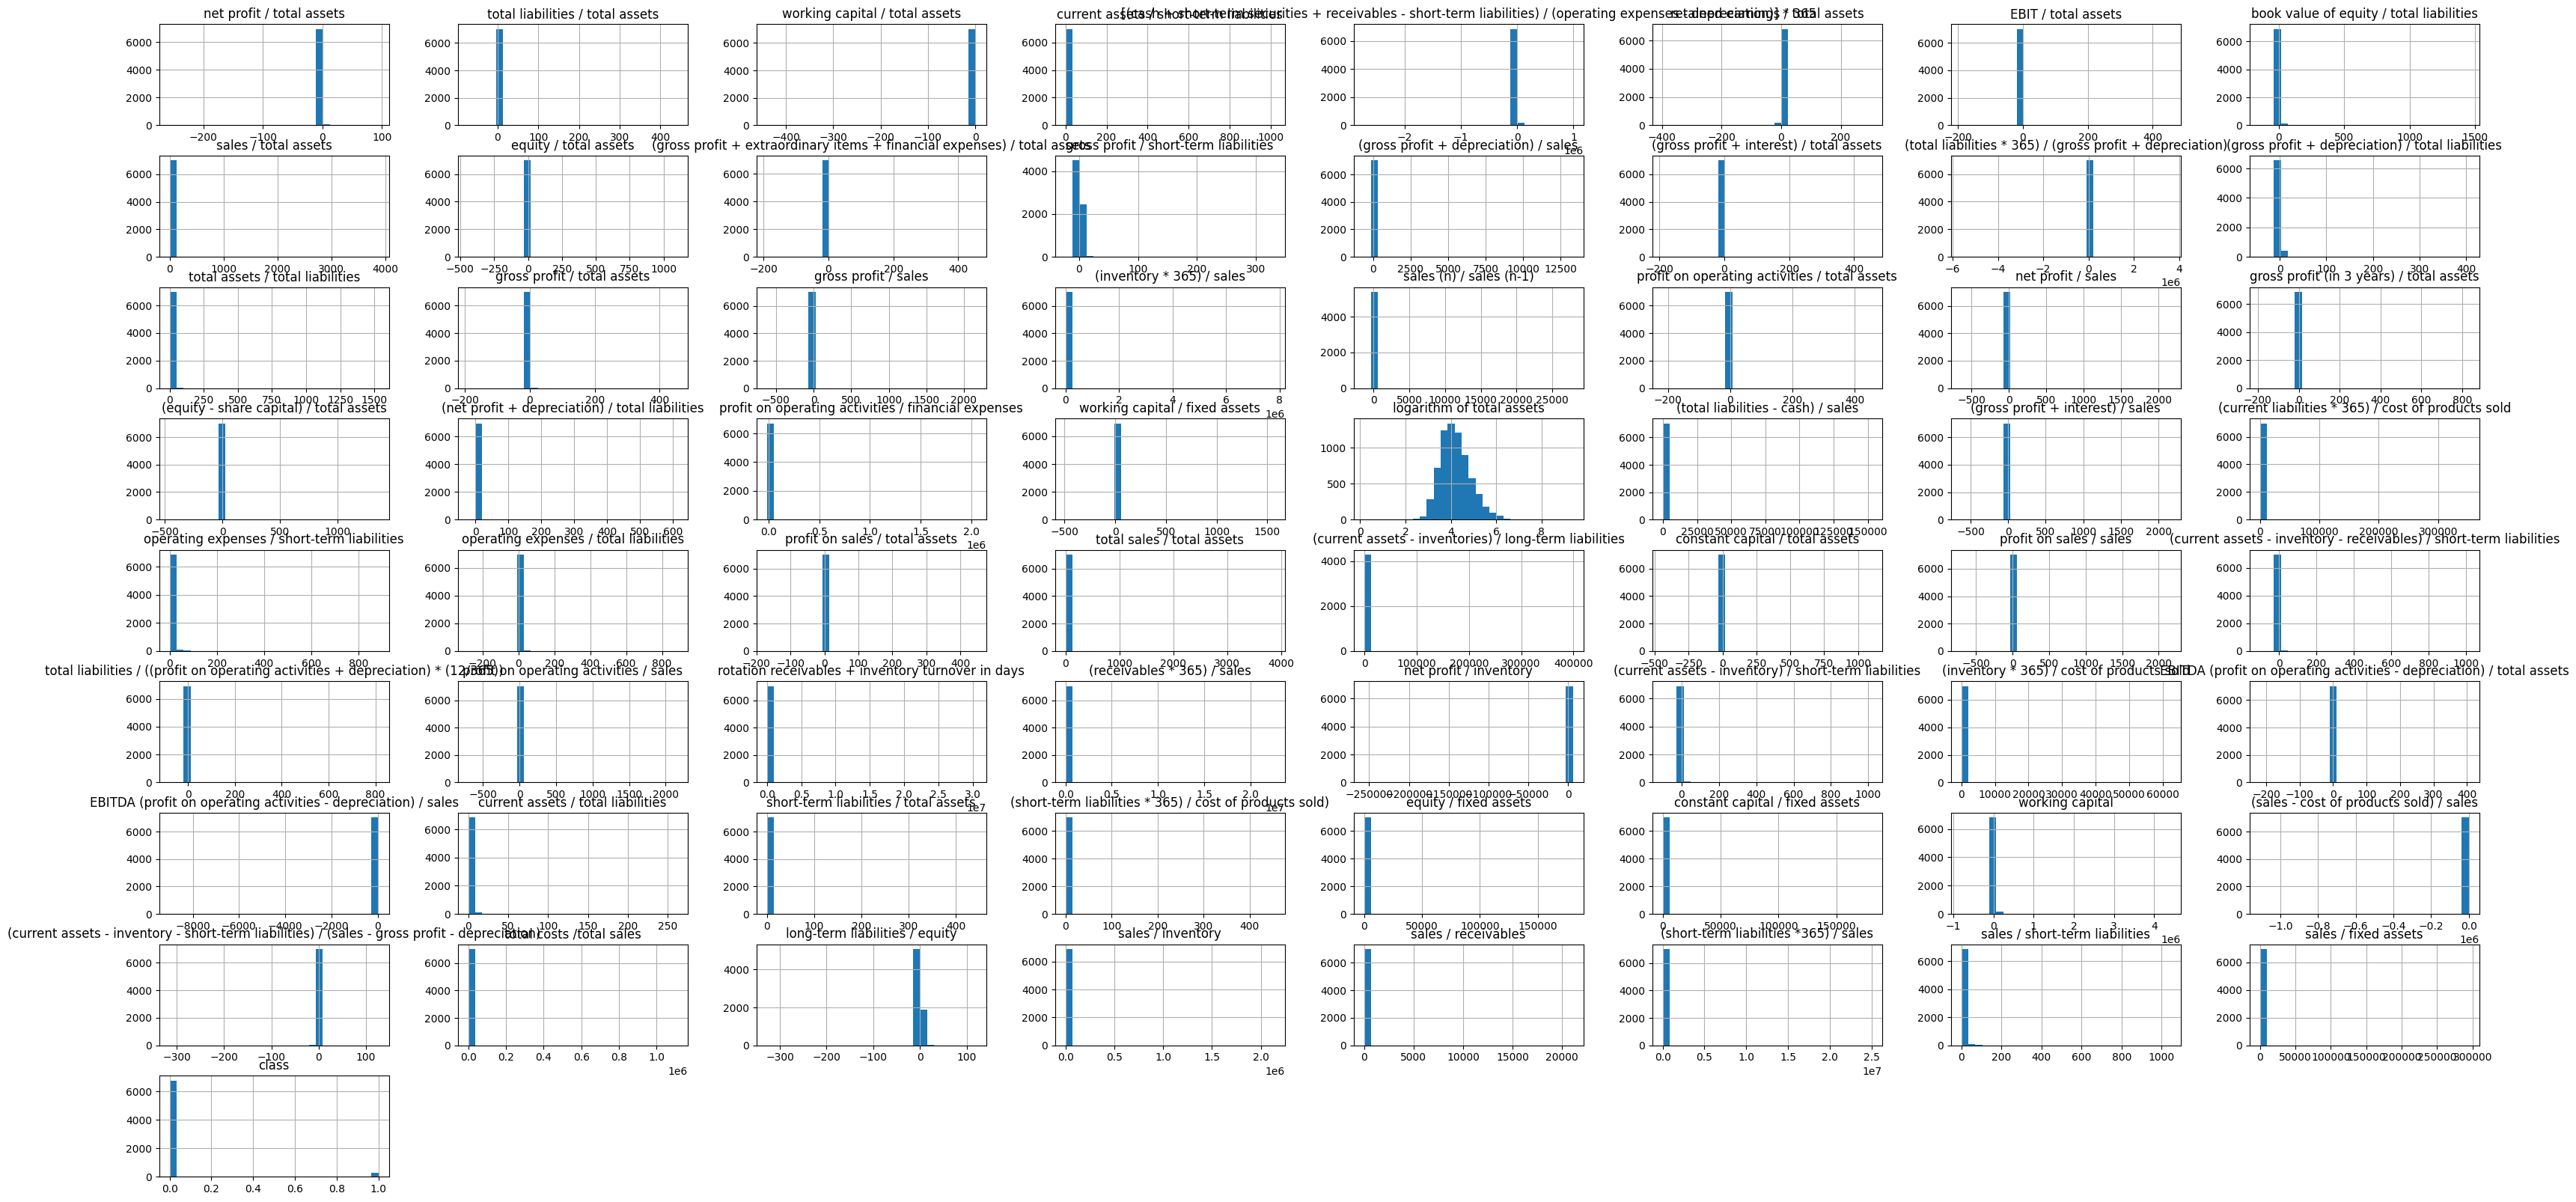

In [10]:
plot_feature_histograms(df, bins=30)

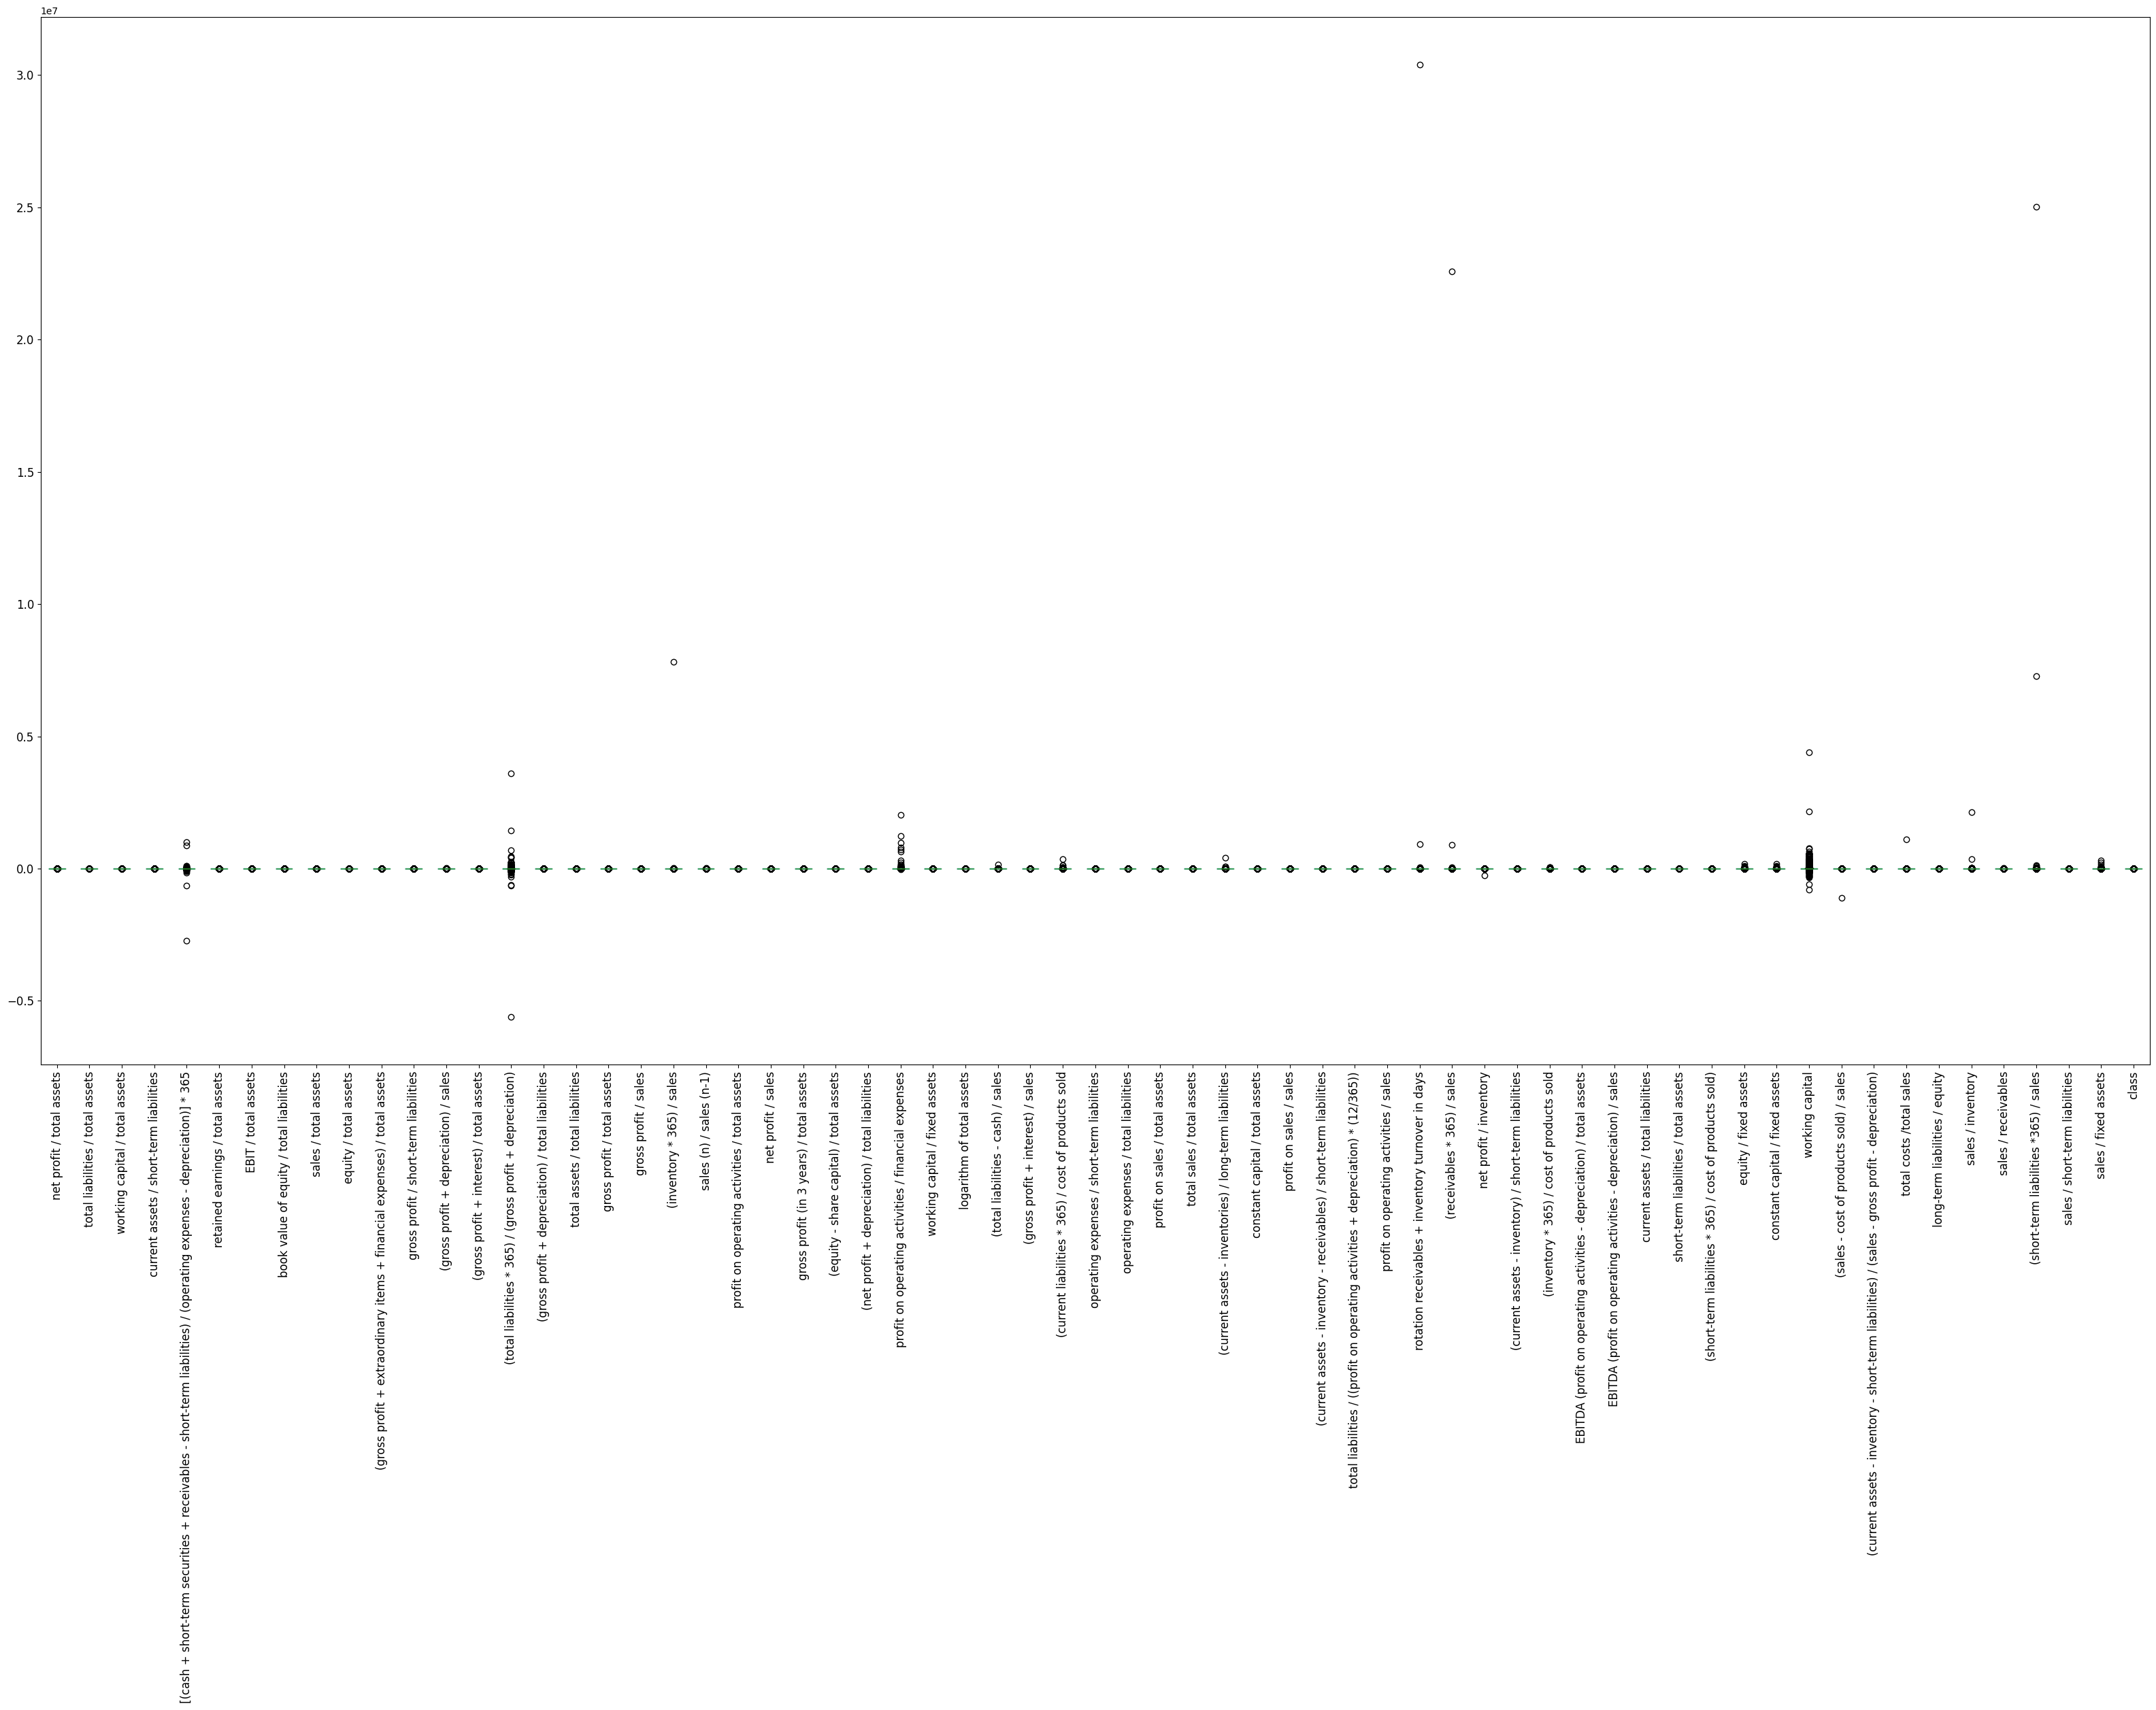

In [11]:
plot_box_plots(df)

**Summary**

1) The feature 'current assets - inventories) / long-term liabilities' has more than 35% missing (null) values in each forecasting period, where 'sales (n) / sales (n-1)' has more than 20% missing values in some forecasting periods.
Nulls in other features need to be handled.

2) Some features (such as 'rotation receivables + inventory turnover in days' and '(short-term liabilities *365) / sales') have high outliers. The distributrions of features are affected by the outliers.

3) In each forecasting period, the dataset is highly imbalanced.

4) The scale of features are varied.

# Data Cleaning

In [4]:
MAJORITY_NULL_PERCENTAGE_CUTOFF = 0.2
OUTLIER_REMOVAL_METHOD = 'ISOLATIONFOREST'
Z_SCORE_LIMITS = [-6,6]
CONTAMINATION = 0.001

In [5]:
for key in dfs:
    df = dfs[key]

    print("Forecasting period", key)

    # Removing features with null % greater than cutoff
    print('Number of Columns Before Removing Features', len(df.columns))
    df = remove_features(MAJORITY_NULL_PERCENTAGE_CUTOFF, df)
    print('Number of Columns After Removing Features', len(df.columns))

    features = df.columns
    print('Length Before Removing Outliers', len(df))
    if (OUTLIER_REMOVAL_METHOD == 'ZSCORE'):
        # Removing outliers by z-score method
        for feature in features:
            df = remove_outliers_by_z_score(df, feature, Z_SCORE_LIMITS)
            print('Length After Removing Outliers', len(df))

    # If Isolation Forest method is selected, it will be done after impute


    dfs[key] = df
    print("\n", end="")

Forecasting period 5
Number of Columns Before Removing Features 65
Removed: (current assets - inventories) / long-term liabilities
Number of Columns After Removing Features 64
Length Before Removing Outliers 5910

Forecasting period 3
Number of Columns Before Removing Features 65
Removed: (current assets - inventories) / long-term liabilities
Number of Columns After Removing Features 64
Length Before Removing Outliers 10503

Forecasting period 2
Number of Columns Before Removing Features 65
Removed: sales (n) / sales (n-1)
Removed: (current assets - inventories) / long-term liabilities
Number of Columns After Removing Features 63
Length Before Removing Outliers 10173

Forecasting period 4
Number of Columns Before Removing Features 65
Removed: (current assets - inventories) / long-term liabilities
Number of Columns After Removing Features 64
Length Before Removing Outliers 9792

Forecasting period 1
Number of Columns Before Removing Features 65
Removed: sales (n) / sales (n-1)
Removed: 

In [6]:
basic_counts(dfs)

,Forecasting Year,Total records,Did Not Bankrupt,Went Bankrupt,Did Not Bankrupt %,Went Bankrupt %
0,5,5910,5500,410,93.062606,6.937394
1,3,10503,10008,495,95.287061,4.712939
2,2,10173,9773,400,96.068023,3.931977
3,4,9792,9277,515,94.740605,5.259395
4,1,7027,6756,271,96.143447,3.856553


# Pre-processing

In [7]:
IMPUTE_METHOD = 'KNN'
KNN_IMPUTE_N_NEIGHBORS = 10
SCALE = True
SCALE_METHOD = 'STANDARD' #'MEAN'
TRAIN_SIZE = 0.8
PCA_COMPONENTS = 20
BALANCE_METHOD = 'UPSAMPLING'
SMOTE_SAMPLING_STRATEGY = 0.8

In [8]:
X_train_map = {}
X_test_map = {}
y_train_map = {}
y_test_map = {}

for key in dfs:
    df = dfs[key]

    print('Forecasting period', key)
    print('Performing train test split')
    X_train, X_test, y_train, y_test = process_data(df, classifier='class', train_size=TRAIN_SIZE, scale=SCALE, scale_method=SCALE_METHOD)

    print('Imputing train and test sets')
    if (IMPUTE_METHOD == 'KNN'):
        X_train = knn_impute(X_train, KNN_IMPUTE_N_NEIGHBORS)
        X_test = knn_impute(X_test, KNN_IMPUTE_N_NEIGHBORS)

    temp = pd.concat([X_train, y_train], axis=1)

    if (OUTLIER_REMOVAL_METHOD == 'ISOLATIONFOREST'):
        print("Removing outliers by isolation forest method")
        for feature in features:
            temp = remove_outliers_by_isolation_forest(temp, feature, CONTAMINATION)

    if (BALANCE_METHOD == 'DOWNSAMPLING'):
        print('Balancing dataset by downsampling')
        temp = balance_by_downsampling(pd.concat([X_train, y_train], axis=1))

    elif (BALANCE_METHOD == 'UPSAMPLING'):
        print('Balancing dataset by upsampling')
        temp = balance_by_upsampling(pd.concat([X_train, y_train], axis=1))

    elif(BALANCE_METHOD == 'DOWNANDUPCOMBINED'):
        print('Balancing dataset by downsampling and upsampling')
        temp = balance_by_down_and_up_sampling(pd.concat([X_train, y_train], axis=1))

    # elif (BALANCE_METHOD == 'SMOTE'):
    #     print('Balancing dataset by smote')
    #     X_train, y_train = balance_by_smote(X_train, y_train, SMOTE_SAMPLING_STRATEGY)

    y_train = temp['class']
    X_train = temp.drop('class', axis=1)

    # X_train, X_test = process_pca(X_train, X_test, n_components=PCA_COMPONENTS)

    print("Length Train -", len(X_train))
    print("Length Test -", len(X_test))
    print("\n", end="")

    X_train_map[key] = X_train
    X_test_map[key] = X_test
    y_train_map[key] = y_train
    y_test_map[key] = y_test

Forecasting period 5
Performing train test split
Imputing train and test sets
Removing outliers by isolation forest method
Balancing dataset by upsampling
Length Train - 8800
Length Test - 1182

Forecasting period 3
Performing train test split
Imputing train and test sets
Removing outliers by isolation forest method
Balancing dataset by upsampling
Length Train - 16012
Length Test - 2101

Forecasting period 2
Performing train test split
Imputing train and test sets
Removing outliers by isolation forest method
Balancing dataset by upsampling
Length Train - 15636
Length Test - 2035

Forecasting period 4
Performing train test split
Imputing train and test sets
Removing outliers by isolation forest method
Balancing dataset by upsampling
Length Train - 14842
Length Test - 1959

Forecasting period 1
Performing train test split
Imputing train and test sets
Removing outliers by isolation forest method
Balancing dataset by upsampling
Length Train - 10808
Length Test - 1407



# Model Building

In [233]:
def baseline(x):
    # Always predicts that the firm did not go bankrupt
    return 0

In [9]:
models = {
    'K Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Histogram Gradient Boosting Classifier': HistGradientBoostingClassifier()
}

def build_nn_model(hidden_layer_sizes=[], activation='relu', optimizer='Adam', learning_rate=0.01):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()
    model.add(keras.layers.Flatten())

    for hidden_layer_size in hidden_layer_sizes:
      model.add(keras.layers.Dense(units=hidden_layer_size, activation=activation))

    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    if optimizer == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
      raise ValueError("Invalid optimizer name provided")

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [235]:
for key in dfs:
    y_test_baseline = X_test_map[key].apply(baseline, axis=1)
    print("Forecasting period", key, "\n")

    baseline_test_accuracy = np.sum(y_test_baseline == y_test_map[key])/len(y_test_map[key])
    print('Baseline Test Accuracy -', '{:.2f}%'.format(baseline_test_accuracy * 100), "\n")

    cm = confusion_matrix(y_test_map[key], y_test_baseline)
    print("Confusion Matrix:")
    print(cm)
    print("\n", end="")
    report = classification_report(y_test_map[key], y_test_baseline)
    print("Classification Report:")
    print(report)
    print("------------------------------------------------------------")

Forecasting period 5 

Baseline Test Accuracy - 93.06% 

Confusion Matrix:
[[1100    0]
 [  82    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1100
           1       0.00      0.00      0.00        82

    accuracy                           0.93      1182
   macro avg       0.47      0.50      0.48      1182
weighted avg       0.87      0.93      0.90      1182

------------------------------------------------------------
Forecasting period 3 

Baseline Test Accuracy - 95.29% 

Confusion Matrix:
[[2002    0]
 [  99    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2002
           1       0.00      0.00      0.00        99

    accuracy                           0.95      2101
   macro avg       0.48      0.50      0.49      2101
weighted avg       0.91      0.95      0.93      2101

---------------------------------

In [236]:
for key in dfs:
    print("Forecasting period", key, "\n")
    X_train = X_train_map[key]
    y_train = y_train_map[key]
    X_test = X_test_map[key]
    y_test = y_test_map[key]

    for name, model in models.items():
        print('Training', name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_accuracy = np.sum(y_pred == y_test)/len(y_test)
        print('Test Accuracy -', '{:.2f}%'.format(test_accuracy * 100), "\n")
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)
        print("\n", end="")
        report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(report)

    model = build_nn_model([8,16], activation='tanh', optimizer='Adam', learning_rate=0.001)

    print('Training Neural network')
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=32,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    predict_x = model.predict(X_test)
    y_pred = np.argmax(predict_x,axis=1)
    test_accuracy = np.sum(y_pred == y_test)/len(y_test)
    print('Test Accuracy -', '{:.2f}%'.format(test_accuracy * 100), "\n")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\n", end="")
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    print("------------------------------------------------------------")

Forecasting period 5 

Training K Neighbors Classifier
Test Accuracy - 83.25% 

Confusion Matrix:
[[957 143]
 [ 55  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1100
           1       0.16      0.33      0.21        82

    accuracy                           0.83      1182
   macro avg       0.55      0.60      0.56      1182
weighted avg       0.89      0.83      0.86      1182

Training Decision Tree Classifier
Test Accuracy - 90.10% 

Confusion Matrix:
[[1041   59]
 [  58   24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1100
           1       0.29      0.29      0.29        82

    accuracy                           0.90      1182
   macro avg       0.62      0.62      0.62      1182
weighted avg       0.90      0.90      0.90      1182

Training Random Forest Classifier
Test Accuracy - 93.49% 

Confusion Matr

Histogram Gradient Boosting Classifier provides the best performance among models

# Histogram Gradient Boosting Classifier - Fine tuning


Note - High precision and low recall with no balancing.
More balance between precision and recall with upsampling

In [45]:
def evaluate_hist_gb_model(X_train, X_test, y_train, y_test, threshold=0.5):
  model = HistGradientBoostingClassifier(max_iter=1000, random_state=42, max_depth=3)
  model.fit(X_train, y_train)

  y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
  print_stats(y_pred, y_test)

In [267]:
THRESHOLD = 0.3

key = '1'
X_train = X_train_map[key]
y_train = y_train_map[key]
X_test = X_test_map[key]
y_test = y_test_map[key]

evaluate_hist_gb_model(X_train, X_test, y_train, y_test, THRESHOLD)

----------------------------------------------------------
Test Accuracy - 96.59% 

Confusion Matrix:
[[1331   21]
 [  27   28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1352
           1       0.57      0.51      0.54        55

    accuracy                           0.97      1407
   macro avg       0.78      0.75      0.76      1407
weighted avg       0.96      0.97      0.96      1407

----------------------------------------------------------


In [283]:
THRESHOLD = 0.2

key = '2'
X_train = X_train_map[key]
y_train = y_train_map[key]
X_test = X_test_map[key]
y_test = y_test_map[key]

evaluate_hist_gb_model(X_train, X_test, y_train, y_test, THRESHOLD)

----------------------------------------------------------
Test Accuracy - 96.07% 

Confusion Matrix:
[[1920   35]
 [  45   35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1955
           1       0.50      0.44      0.47        80

    accuracy                           0.96      2035
   macro avg       0.74      0.71      0.72      2035
weighted avg       0.96      0.96      0.96      2035

----------------------------------------------------------


In [21]:
THRESHOLD = 0.5

key = '3'
X_train = X_train_map[key]
y_train = y_train_map[key]
X_test = X_test_map[key]
y_test = y_test_map[key]

evaluate_hist_gb_model(X_train, X_test, y_train, y_test, THRESHOLD)

----------------------------------------------------------
Test Accuracy - 96.14% 

Confusion Matrix:
[[1970   32]
 [  49   50]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2002
           1       0.61      0.51      0.55        99

    accuracy                           0.96      2101
   macro avg       0.79      0.74      0.77      2101
weighted avg       0.96      0.96      0.96      2101

----------------------------------------------------------


In [34]:
THRESHOLD = 0.2

key = '4'
X_train = X_train_map[key]
y_train = y_train_map[key]
X_test = X_test_map[key]
y_test = y_test_map[key]

evaluate_hist_gb_model(X_train, X_test, y_train, y_test, THRESHOLD)

----------------------------------------------------------
Test Accuracy - 94.84% 

Confusion Matrix:
[[1821   35]
 [  66   37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1856
           1       0.51      0.36      0.42       103

    accuracy                           0.95      1959
   macro avg       0.74      0.67      0.70      1959
weighted avg       0.94      0.95      0.94      1959

----------------------------------------------------------


In [46]:
THRESHOLD = 0.5

key = '5'
X_train = X_train_map[key]
y_train = y_train_map[key]
X_test = X_test_map[key]
y_test = y_test_map[key]

evaluate_hist_gb_model(X_train, X_test, y_train, y_test, THRESHOLD)

----------------------------------------------------------
Test Accuracy - 94.42% 

Confusion Matrix:
[[1079   21]
 [  45   37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1100
           1       0.64      0.45      0.53        82

    accuracy                           0.94      1182
   macro avg       0.80      0.72      0.75      1182
weighted avg       0.94      0.94      0.94      1182

----------------------------------------------------------


# Results

In [55]:
# Baseline Results
baseline_results = [
    [1, '96.09%', 0.96, 1.00, 0, 0],
    [2, '96.07%', 0.96, 1.00, 0, 0],
    [3, '95.29%', 0.95, 1.00, 0, 0],
    [4, '94.74%', 0.95, 1.00, 0, 0],
    [5, '93.06%', 0.93, 1.00, 0, 0]
]

baseline_results = pd.DataFrame(baseline_results, columns=['Forecasting Period', 'Accuracy', 'Class 0 Precision',
                                         'Class 0 Recall', 'Class 1 Precision', 'Class 1 Recall'])
baseline_results

,Forecasting Period,Accuracy,Class 0 Precision,Class 0 Recall,Class 1 Precision,Class 1 Recall
0,1,96.09%,0.96,1.0,0,0
1,2,96.07%,0.96,1.0,0,0
2,3,95.29%,0.95,1.0,0,0
3,4,94.74%,0.95,1.0,0,0
4,5,93.06%,0.93,1.0,0,0


In [53]:
# Histogram Gradiet Boosting Classifier Results
hgb_results = [
    [1, '96.59%', 0.98, 0.98, 0.57, 0.51, 0.3, 1000, 3],
    [2, '96.07%', 0.98, 0.98, 0.50, 0.44, 0.2, 1000, 4],
    [3, '96.14%', 0.98, 0.98, 0.61, 0.51, 0.5, 1000, 3],
    [4, '94.84%', 0.97, 0.98, 0.51, 0.36, 0.2, 1500, 5],
    [5, '94.42%', 0.96, 0.98, 0.64, 0.45, 0.5, 1000, 3]
]

hgb_results = pd.DataFrame(hgb_results, columns=['Forecasting Period', 'Accuracy', 'Class 0 Precision',
                                         'Class 0 Recall', 'Class 1 Precision', 'Class 1 Recall',
                                         'Threshold', 'HGB Max Iterations', 'HGB Max Depth'])
hgb_results

,Forecasting Period,Accuracy,Class 0 Precision,Class 0 Recall,Class 1 Precision,Class 1 Recall,Threshold,HGB Max Iterations,HGB Max Depth
0,1,96.59%,0.98,0.98,0.57,0.51,0.3,1000,3
1,2,96.07%,0.98,0.98,0.50,0.44,0.2,1000,4
2,3,96.14%,0.98,0.98,0.61,0.51,0.5,1000,3
3,4,94.84%,0.97,0.98,0.51,0.36,0.2,1500,5
4,5,94.42%,0.96,0.98,0.64,0.45,0.5,1000,3
